# Xarxa Neuronal Bàsica amb MNIST

Aquest document ha estat creat per l'[Eric Alcaide](https://github.com/EricAlcaide). Crèdits a [Hvass-Labs](https://github.com/Hvass-Labs) pel codi en versió original que ha estat modificat i traduït per als propòsits d'aquest treball.


## Introducció

Aquest arxiu ha estat creat amb l'objectiu de demostrar que els ordinadors poden aprendre. En aquest cas, entrenarem una xarxa neuronal bàsica per tal de reconèixer caràcters escrits a mà.

Primerament, carregarem el set de dades MNIST, un conjunt de 70.000 imatges de números escrits a mà amb la seva corresponent classificació/etiqueta. Aquestes 70.000 imatges es divideixen en: 55.000 imatges per a l'entrenament, 5.000 imatges per a la validació i 10.000 més per a l'avaluament.
Posteriorment crearem el **model** (part del programa que serà l'encarregada "d'aprendre") amb Tensorflow, l'entrenarem per tal d'optimitzar la seva eficàcia i l'avaluarem. Posteriorment comentarem els resultats obtinguts i extreurem conclusions. 

Les llibreries/dependències que usarem seran les següents:
* **Numpy:** per tal de fer càlculs matemàtics 
* **Tensorflow:** per tal de crear el model
* **Matplotlib:** per tal d'imprimir els gràfics i visualitzar les dades

## Definició del problema

Es tracta clarament d'un **problema de classificació** ja que a partir d'unes dades d'entrenament hem de ser capaços de classificar correctament unes dades que desconeixem. El nostre set d'imatges conté números que van del 0 al 9, per tant, són 10 números diferents. Això ens obliga a crear 10 classes diferents, una per a cada número.

Com el nostre propòsit és crear un model el més basic possible, crearem una xarxa neuronal amb 10 neurones, amb l'esperançca que cadascuna s'activi al reconèixer un dígit diferent diferent. Per tant, podem dir que la xarxa neuronal que anem a crear és de capa única. Per a aplicacions reals existeixen xarxes neuronals molt més sofisticades que aconsegueixen molt millors resultats com ara xarxes multicapa, recurrents, convolucionals, etc.

## Importem les llibreries necessàries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

*Important: Aquest projecte ha estat desenvolupat amb Python v3.5.3 i Tensorflow v1.0.1*

## Carreguem les dades

El set de dades MNIST (Modified National Institute of Standards and Technology database), d'aproximadament unes 12MB de pes, serà descarregat automàticament en cas de no trobar-se en la direcció indicada.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Seguidament comprobarem el tamany dels subsets d'entrenament, validació i avaluació per tal de confirmar que les dades que hem recol·lectat són correctes

In [3]:
print("Tamany:")
print("   - Subset d'entrenament:   ", len(mnist.train.labels))
print("   - Subset de validació:    ", len(mnist.validation.labels))
print("   - Subset d'avaluació:     ", len(mnist.test.labels))

Tamany:
   - Subset d'entrenament:    55000
   - Subset de validació:     5000
   - Subset d'avaluació:      10000


## Codificació "One-Hot"

El set de dades MNIST ha estat carregat amb codificació "One-Hot", com podem veure aquí: `one_hot=True`. Això significa que les etiquetes dels nombres han estat convertides d'un únic dígit (ex. 7), a un vector de 10 dimensions en el qual una d'elles és un 1 i les altres 0. Aquest tipus de codificació representa un avantatge per al nostre model, com veurem posteriorment.

Per tal de visualitzar la codificació "One-Hot", imprimirem l'etiqueta dels 5 primers nombres del subset d'avaluació:

In [4]:
print(mnist.test.labels[0:5, :])

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


Aquests vectors es poden interpretar com a números enters si prenem la posició de l'1 com a referència i li restem 1. Seguint aquesta interpretació, les corresponents etiquetes serien: 7, 2, 1, 0, 4.

També necessitarem les etiquetes en format de dígit únic per a diverses mesures de comparació i d'avaluació de l'eficàcia del nostre model, així que anem a guardar-les d'aquesta manera també.

Aquí és on comencem a utilitzar les funcionalitats de la llibreria NumPy per crear matrius de forma molt eficient. En aquest cas usarem la funció `argmax()` per tal d'extreure la posició del valor més alt. A Python, com a la majoria de llenguatges de programació, els índexs de les llistes i/o matrius comencen amb el 0, així quen no necessitem restar res.

In [5]:
mnist.test.etiquetes = np.array([onehot.argmax() for onehot in mnist.test.labels])

Acte seguit, imprimirem les 5 primeres etiquetes per comprobar que les dades que hem guardat són correctes:

In [6]:
print(mnist.test.etiquetes[0:5])

[7 2 1 0 4]


## Dimensions de les dades

Necessitarem una sèrie de paràmetres sobre el nostre set de dades per tal d'entrenar el model. Idealment, aquests paràmetres es podrien extreure del set de dades, però com ja els coneixem, els declararem simplement.

In [7]:
# Sabem que les imatges d'MNIST són de 28x28 píxels
tamany_img = 28
# Les imatges són guardades en una matriu unidimensional o un vector de la següent longitud.
img_tamany_pla = tamany_img * tamany_img
# Tupla amb les dimensions de les imatges usada per redimensionar les matrius.
forma_img = (tamany_img, tamany_img)
# Nombre de classes diferents, una classe per cada número.
num_classes = 10

És important veure el que estem preparant en aquesta línia:
```
img_tamany_pla = tamany_img * tamany_img
```
Com un programa d'ordinador no pot "veure" com nosaltres, el que fem es agafar les imatges de 28x28 i posar-les en forma de vector unidimensional de 28x28= 784 dimensions. Aquest vector serà després proporcionat a la xarxa neuronal per tal de ser classificat.

## Funcions auxiliars per tal d'imprimir imatges

La següent funció serà usada per tal d'imprimir 9 imatges en format 3x3 amb la seva classificació real i la classficació predita pel nostre model:

In [8]:
def imprimeix_imgs(imgs, classe_real, classe_pred=None):
    # Ens assegurem que hi ha tant 9 imatges com 9 etiquetes
    assert len(imgs) == len(classe_real) == 9
    
    # Creem la figura amb 3x3 sub-imatges.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    # Imprimim les imatges amb un bucle.
    for i, ax in enumerate(axes.flat):
        # Imprimim imatge.
        ax.imshow(imgs[i].reshape(forma_img), cmap='binary')

        # Mostrem la classificació real i la predita pel model només si la hem proporcionat.
        if classe_pred is None:
            xlabel = "Realitat: {0}".format(classe_real[i])
        else:
            xlabel = "Realitat: {0}, Pred: {1}".format(classe_real[i], classe_pred[i])

        ax.set_xlabel(xlabel)
        # Treiem els índexs dels eixos x i y.
        ax.set_xticks([])
        ax.set_yticks([])

## Imprimim algunes imatges per veure si les dades són correctes

Aquestes són les primeres 9 imatges del subset d'avaluació amb la seva corresponent classificació:

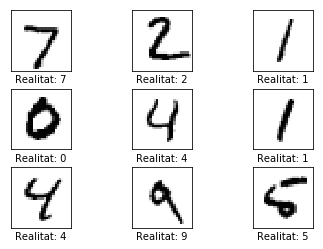

In [9]:
imgs = mnist.test.images[0:9]
classe_real = mnist.test.etiquetes[0:9]
# Imprimim les imatges i les classificacions usant la funció declarada més amunt.
imprimeix_imgs(imgs=imgs, classe_real=classe_real)

## Grafs de Tensorflow

L'objectiu principal de l'utilització de TensorFlow és que proporciona moltes utilitats per tal de crear models. Una de les principals característiques de TensorFlow és que primer es construeix el graf computacional, que és una representació de totes les operacions que es duen a terme i les dades que es manipulen, i després s'executa aquest graf. D'aquesta manera, les operacions es poden dur a terme infinítament més ràpid que si les escrvíssim directament a Python. Tensorflow pot ser fins i tot més ràpid que Numpy ja que Tensorflow coneix tot el graf computacional mentre que Numpy fa una operació a cada pas.

A més, Tensorflow pot calcular directament els gradients necessaris per tal d'optimitzar la nostra xarxa neuronal sense que nosaltres ho haguem de fer manualment, cosa que facilita molt el procés i augmenta la velocitat increïblement. Tensorflow, a més, pot córrer tant en CPUs com en GPUs i pot fins i tot córrer en diverses GPUs a la vegada.

Els principals elements del graf de Tensorflow són els següents:
* **Placeholders**: Variables especials que s'utilitzen per introduïr dades al graf.
* **Variables del model**: Varaibles que han de ser optimitzades per tal que el nostre model funcioni el millor possible. 
* **Model**: Essencialment una funció matemàtica que calcula un resultat de sortida donats unes dades d'entrada en forma de placeholders i variables de model
* **Mesura de cost**: Aquesta mesura serà usada per tal de guiar la optimització del model. Pot trobar-se en dues formes diferents:
    * La primera és una funció que mesuri com de bo és el nostre model. Aquesta funció s'ha de maximitzar.
    * La segona, i **molt més comuna**, és una funció que mesuri com de dolent és el nostre model. Aquesta funció s'ha de minimitzar.
    
    
* **Mètode d'Optimització**. Mètode que usarem per tal de millorar el nostre model. Usarem un dels més comuns i a la vegada siumples: el **Gradient Descent** , que ja havíem usat per al perceptró.

### Placeholders

Començarem per definir el placeholder `x` per a les imatges. Tindrà dues dimensions: una amb el nombre d'imatges i l'altra amb la imatge en forma de vector unidimensional de 784 dimensions.
Posarem el nombre d'imatges com a `None` perquè el decidirem més tard de forma arbitrària.

In [10]:
x = tf.placeholder(tf.float32, [None, img_tamany_pla])

Seguidament declararem el placeholder `y_real`, amb les etiquetes corresponents a les imatges d'entrada a x amb codificació "One-Hot".


In [11]:
y_real = tf.placeholder(tf.float32, [None, num_classes])

Per últim, declararem el placeholder `y_real_ver`, que contindrà les etiquetes per a les imatges introduïdes a x però aquest cop seràn un dígit únic.

In [12]:
y_real_ver = tf.placeholder(tf.int64, [None])

### Variables de model

Acte seguit definim les variables a ser optimitzades per tal de millorar l'eficàcia del nostre model.

En primer lloc, declararem els pesos de les diferents neurones, que seran inicialitzats a 0.

In [13]:
pesos = tf.Variable(tf.zeros([img_tamany_pla, num_classes]))

La segona variable a ser optimitzada serà anomenada `des` i serà la **d** en la següent equació linear: **y = p·x + d** on **y** és la classificació, **p** els pesos i **x** les imatges d'entrada en forma de vector unidimensional. Serà un vector unidimensonal de longitud 10 (número de classes) que tam,bé inicialitzarem a 0.

In [14]:
des = tf.Variable(tf.zeros([num_classes]))

### Model

El nostre model serà força simple i només requerirà multiplicar les matrius X i P i afegir les desviacions D.
Anomenarem `logits` al nostre model degut a que és un nom força usat a la comunitat de Tensorflow.

In [15]:
logits = tf.matmul(x, pesos) + des

Ara `logits` es una matriu amb tantes columnes com imatges hem proporcionat i tantes columnes com classes diferents (10), on l'element de la fila **_i_** i la columna **_j_** és l'estimació de la probabilitat que la imatge **_i_** pertanyi a la classe **_j_**.

Però encara no hem acabat, ja que els nombres poden ser o massa grans o massa petits. El següent pas és normalitzar aquests números per tal que tots els components d'una fila sumin 1 i tots els valors es trobin entre 0 i 1. D'aquesta manera, el valor més gran serà la predicció del nostre model. Per tal de dur a terme aquesta normalització, usarem la funció `softmax`.


In [16]:
y_pred = tf.nn.softmax(logits)

Acte seguit hem d'extreure el valor més gran de cada fila, que serà la nostra predicció per a la imatge.

In [17]:
y_pred_classe = tf.argmax(y_pred, dimension=1)

### Mesura de cost

Com a mesura de cost utilitzarem l'anomenada `cross-entropy` o entropia creuada. L'entropia entre dues classes ve donada per la funció 

**E = - ((-P<sub>1</sub> x log<sub>2</sub> P<sub>1</sub>) + (P<sub>2</sub> x log<sub>2</sub> P<sub>2</sub>))** 

Nosaltres la calcularem entre els diferents números de les classificacions, la del nostre model i la classificació correcta en forma "One-Hot". Després sumarem les 10 entropies de les 10 classes diferents per obtenir l'entropia creuada.  

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_real)

L'entropia creuada ens serveix per mesurar com està funcionant el nostre model per a cada imatge individualment, però si volem guiar el procés d'optimització amb aquesta mesura de cost hem d'aconseguir una mesura global, no individual. Per aquesta raó, farem la mitjana entre les diferents entropies creuades per a les diferents imatges.

In [19]:
cost = tf.reduce_mean(cross_entropy)

### Mètode d'optimització

L'optimitzador que usarem serà el Gradient Descent, i declararem l'índex d'aprenentatge arbitràriament a 0.1. Si l'índex és massa petit necessitarem massa iteracions per tal d'aconseguir un bon resultat, però si és massa gran, anirem saltant d'una banda a l'altra i també necessitarem més iteracions de les necessàries.

In [20]:
optimitzador = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

### Mesures d'eficàcia

Per mesurar l'eficàcia del nostre model, usarem la precisió o "accuracy", que és el percentatge d'encerts respecte del total. També usarem el nombre d'encerts per cada error.

Primerament crearem un vector de valors booleans (True/False) per tal de saber si les classificacions han estat efectuades correctament.

In [21]:
pred_correcte = tf.equal(y_pred_classe, y_real_ver)

Ara canviarem els valors booleans True/False pels nombres 1/0 i mesurarem el percentatge. També calcularem el rati encerts/errors.

In [22]:
canviat = tf.cast(pred_correcte, tf.float32)
precisio = tf.reduce_mean(canviat)
rati = tf.divide(tf.reduce_sum(canviat), tf.cast(tf.shape(pred_correcte), tf.float32))

## Activem Tensorflow

Després de construir el graf computacional, és el moment de córrer tensorflow. Primer inicialitzarem les variables i després declararem la sessió.

In [23]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

### Funció auxiliar per dur a terme iteracions d'entrenament

Com hi ha 55.000 imatges per a l'entrenament i seria molt lent haver de calcular tots els gradients per a cada iteració d'entrenament, entrenarem el model amb grups de 100 imatges.

In [24]:
tamany_grup = 100

Ara declararem la funció que dura a terme els episodis d'entrenament. Per a cada iteració, es seleccionaran 100 imatgtes i les seves etiquetes i s'introduïran al model per tal que Tensorflow faci les optimitzacions corresponents.

In [25]:
def optimitza(num_iteracions):
    for i in range(num_iteracions):
        # Agafem un grup d'imatges.
        # x_grup serà el grup d'imatges
        # y_real_grup serà el grup d'etiquetes correctes.
        x_grup, y_real_grup = mnist.train.next_batch(tamany_grup)
        
        # Posem el grup a un diccionari amb els noms dels placeholders
        # per introduïr les dades al graf de Tensorflow.
        diccionari_entrenament = {x: x_grup,
                           y_real: y_real_grup}

        # Activem el model usant aquest grup d'imatges.
        # TensorFlow assigna les variables al diccionari_entrenament
        # als placeholders i després activa el model.
        sess.run(optimitzador, feed_dict=diccionari_entrenament)

### Funcions auxiliars per mostrar l'eficàcia

Primerament declararem un diccionari d'avaluació per tal d'avaluar el model amb imatges que encara no hagi vist per tal de veure si és capaç de generalitzar i, per tant, **aprendre**.

In [26]:
diccionari_test = {x: mnist.test.images,
                  y_real: mnist.test.labels,
                  y_real_ver: mnist.test.etiquetes}

La següent funció servirà per imprimir els resultats:

In [27]:
def imprimeix_res(precisio,rati):
    # Usem Tensoflow per obtenir els resultats
    pres = sess.run((precisio,rati), feed_dict=diccionari_test)
    
    (precisio,rati) = pres
    rati = [rati*10, 10-rati*10]
    rati = [x/min(rati[0], rati[1]) for x in rati]
    # Imprimeix els resultats.
    print("Precisió al set d'avaluació:", precisio*100)
    print("Rati encerts/errors:        ", float(rati[0]),":",float(rati[1]))

In [28]:
imprimeix_res(precisio, rati)

Precisió al set d'avaluació: 9.7999997437
Rati encerts/errors:         1.0 : 9.204082489013672


Com podem veure, la precisió està al voltant del 10%. Això és degut a que el model classifica inicialment tots els números com a 0 ja que encara no s'ha dut a terme cap episodi d'entrenament.

Per tal de mostrar el que el model interpreta com un número, crearem la funció `mostra_pesos`, que mostrarà el conjunt de pesos que l'ordinador usa per tal de classofocar un número.

In [29]:
def mostra_pesos():
    # Agafa els valors dels pesos del graf de Tensorflow
    p = sess.run(pesos)
    
    # Agafa els valors màxims i mínims per als pesos.
    # Això serà usat per tal de construir el mapa de calor
    # i poder comparar les imatges entre elles.
    p_min = np.min(p)
    p_max = np.max(p)

    # Crea una figura amb 3x4 objectes
    # Els últims 2 no s'usen
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            # Agafa els pesos per al digit i i redimensiona'l
            # AtenciÖ: p.shape == (img_tamany_pla, 10)
            image = p[:, i].reshape(forma_img)

            # Declara l'etiqueta per a cada objecte.
            ax.set_xlabel("Pesos: {0}".format(i))

            # Mostra la imatge. Els punts verds són positius i els vermells negatius.
            ax.imshow(image, vmin=p_min, vmax=p_max, cmap='seismic_r')
            
        # Treiem els índexs dels eixos x i y.
        ax.set_xticks([])
        ax.set_yticks([])

Visualitzem els pesos quan encara no hem dut a terme cap iteració. Podem veure que inicialment tots punts tenen la mateixa classificació com a penalització.


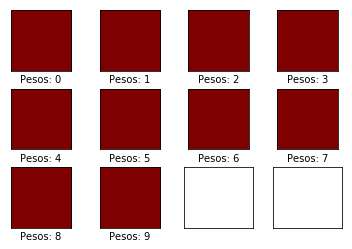

In [30]:
mostra_pesos()

Per veure el procés d'aprenentatge, primer efectuarem una prova amb 25 iteracions, visualitzarem els pesos i després farem l'entrenament real amb 10000 iteracions.

Precisió al set d'avaluació: 82.0599973202
Rati encerts/errors:         4.57413387298584 : 1.0


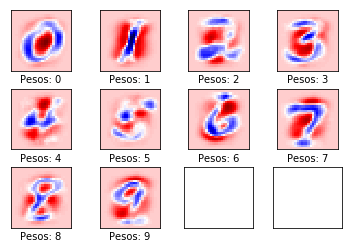

In [31]:
optimitza(25)
imprimeix_res(precisio, rati)
mostra_pesos()

Com podem veure, el model, tot i ser molt simple (només 10 neurones en una única capa), ha après amb només 25 iteracions més o menys la forma que té un 0, un 1, un 6, un 2, un 8 i un 7. L'eficàcia del model encara és una mica fluixa (80% d'encerts amb una taxa d'errors d'un per cada 4 encerts).

A continuació durem a terme l'entrenament real.

Precisió al set d'avaluació: 92.3099994659
Rati encerts/errors:         12.003900527954102 : 1.0


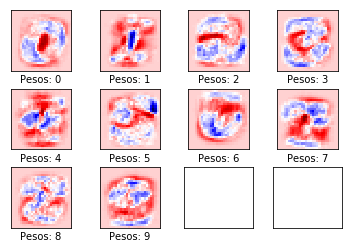

In [32]:
optimitza(10000)
imprimeix_res(precisio, rati)
mostra_pesos()

## Conclusions

Com podem veure a dalt, el nostre simple model ha estat capaç d'aprendre a reconèixer els diferents dígits escrits a mà amb una precisió del 92%. El fet és que 92% d'eficàcia a MNIST no és gaire bo, però el propòsit d'aquest "experiment" no era aconseguir una precisió envejable, sinó demostrar que un ordinador pot aprendre, en aquest cas, a reconèixer dígits escrits a mà.

Si mirem els pesos de l'últim entrenament, podem veure que no són exactament el que nosaltres esperaríem. Sembla ser que l'ordinador ha posat totes les imatges de cada número l'una a sobre de l'altra i ha agafat els punts comuns i els no comuns i això causa aquests pesos, on sembla que l'ordinador es guia més pels punts que representen una "penalització" (vermells) que pels que representen un "benefici" (blaus).

Si retrocedim una mica als pesos que hem mostrat després de les primeres 25 iteracions podem veure que aquells eren una mica més clars, més semblants al que esperaríem, però la precisió llavors era més o menys un 80% mentre que ara és del 92% i el rati d'encerts/errors és de 12 encerts per cada error.

La conclusió més important que podem extreure d'aquest "experiment" és que els ordinadors NO aprenen com nosaltres, ja que no són persones. El seu aprenentatge es pot semblar al nostre, però mai serà igual. No obstant, són capaços d'aprendre, i això ja és molt.